In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import  matplotlib.pyplot as plt 
from scipy.stats import norm 
import datetime 
%matplotlib inline

REMARQUE préliminaire: 

On ré-extrait les données financières  à chaque fois qu'un algorithme en a besoin pour que nos algorithmes soient indépendants les uns des autres.Ainsi nous pourrons modifier les années et les actions d'un algorithme  sans perturber le bon fonctionement du reste du programme. 

## Méthode 1: minimisation du risque sous contrainte de rendement par descente de gradient


In [ ]:
#Fonction objective F
#Fonction calcul de Risque
def F(A,x):
  return (np.dot(np.dot(np.transpose(x),A),x))

In [ ]:
#Fonction de risque ie retourne la volatilité classique (en poids), en effet ici la solution x trouvée représente la répartition en somme on en conclut donc:
def risqueportefeuille(A,x,S):
  return (1/S)*(F(A,x))**(1/2)


In [ ]:
#Point de départ Algo
def simulation(S):
  z=np.random.rand(1,4)
  x=(z/np.sum(z))*S
  return list(x)

In [ ]:
#gradient de la fonction objective  
def df(A,x):
  return np.dot(A+np.transpose(A),x)

In [ ]:
def PK(A,C, g, b, tau, tol, Niter):
    xn,lambdan = b, np.dot(C, b)
    for n in range(Niter):
        xnp1 = np.dot(C.transpose(), lambdan) + b 
        if np.linalg.norm(np.array(xnp1 -xn),2) < tol:
          return xnp1
        xn = xnp1
        for i in range(len(lambdan)):
          lambdan[i] = min(0, (lambdan + tau*(g - np.dot(C,xn)))[i])
    print("l’algorithme d’Uzawa n’a pas convergé")
    return xnp1

In [ ]:
def gradientPasConstant(A,C,g,df,PK ,x0, tol,Niter):
    x0=np.transpose(x0)
    xn,L = PK(A,C,g,x0,0.1,0.1,1000),[]
    for n in range(Niter):
        tau=0.2
        xnP1=PK(A,C,g,np.transpose(xn-tau*df(A,xn)),tau,0.1,1000)
        if np.linalg.norm(np.array(xnP1-xn)) < tol:
            return xn, L
        L.append(xn)
        xn = xnP1
    return xn, L

*Vérification de la convergence de l'algorithme*

Entrez l'année 2013
Montant investissement conseillé entre 100 et 1000 100
Rendement en euro  désiré /conseillé entre 15% et 30% du montant investi 36.75


Text(0.5, 0, 'Itérations')

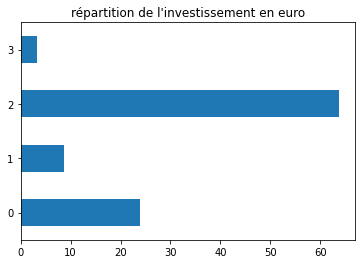

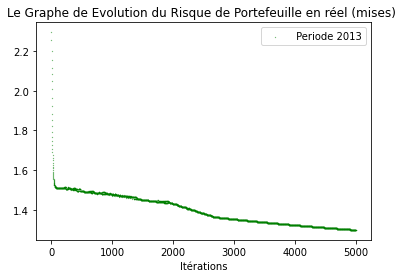

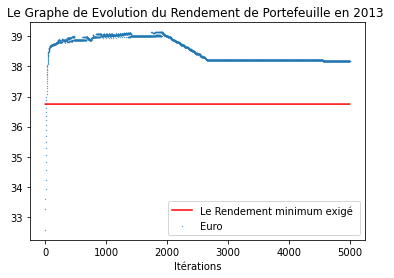

In [ ]:
#Procédure Vérification Convergence Algorithme
annee=int(input("Entrez l'année "))
ticker=["AMZN","MSFT","GOOGL","AAPL"]
data=pd.DataFrame()
data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(annee,1,1),end=datetime.date(annee+1,3,1))["Adj Close"]
data_yield=np.log(1+data.pct_change())
data_yield.head()
daily_yield=data_yield.mean()
#on ramène ça sur une année en supposant qu'il y a 250 jours de trading 
annual_yield=daily_yield*250
#matrice covariance des rendements 
data_cov=data_yield.cov()
S=float(input('Montant investissement conseillé entre 100 et 1000 '))
R0=float(input('Rendement en euro  désiré /conseillé entre 15% et 30% du montant investi '))
Niter=5000


C=np.array([np.array([1,1,1,1]),np.array([-1,-1,-1,-1]),-np.array([1,0,0,0]),-np.array([0,1,0,0]),-np.array([0,0,1,0]),-np.array([0,0,0,1]),-np.array(annual_yield)])
g=np.transpose(np.array([S,-S,0,0,0,0,-R0]))
A=np.array(data_cov)

#Lancement Algorithme 1 étape
z=np.array(simulation(S)[0])
xsol,Lsol=gradientPasConstant(A,C,g,df,PK,z,0.001, Niter=5000)

#Graphe 

plt.figure()
pd.Series(xsol).plot.barh()
plt.title("répartition de l'investissement en euro")
  
plt.figure()
xx=range(1,len(Lsol)+1) 
yy=[]

for i in range(len(Lsol)):
  yy.append(F(A,Lsol[i]))

plt.scatter(xx,yy,s=0.05,c='green',label=" Periode {}".format(annee)) 
plt.legend()
plt.title('Le Graphe de Evolution du Risque de Portefeuille en réel (mises) ')
plt.xlabel("Itérations")

plt.figure()
xx=range(1,len(Lsol)+1) 
yy=[]    
for j in range(len(Lsol)):
      S=np.dot(annual_yield,Lsol[j])
      yy.append(S)
plt.scatter(xx,yy,s=0.1,label='Euro')
plt.legend()
plt.plot([R0 for i in range(1,len(Lsol))],label='Le Rendement minimum exigé ',c='red')
plt.legend()
plt.title("Le Graphe de Evolution du Rendement de Portefeuille en {} ".format(annee))
plt.xlabel("Itérations")

## Méthode 2: maximisation du rendement sous contrainte de risque par méthode de pénalisation 

In [ ]:
#Ecriture des contraintes


#Fonction n'intervient pas dans l'algorithme mais très utile conceptuellement 

def penalisation(sigma0,S0,x,A):
  f1=S0-np.dot(np.array([1,1,1,1]),x)
  f2=sigma0**2-np.dot(x,np.dot(A,x))
  f3=np.dot(np.eye(4,4),x)
  if (f1<0) :
    theta1=abs(f1)
  elif f1>=0:
    theta1=0
  if (f2<0) :
    theta2=abs(f2)
  elif f2>=0:
    theta2=0
  if (f3[0]<0) :
    theta3=abs(f3[0])
  elif f3[0]>=0:
    theta3=0
  if (f3[1]<0) :
    theta4=abs(f3[1])
  elif f3[1]>=0:
    theta4=0
  if (f3[2]<0) :
    theta5=abs(f3[2])
  elif f3[2]>=0:
    theta5=0
  if (f3[3]<0) :
    theta6=abs(f3[3])
  elif f3[3]>=0:
    theta6=0
  return (theta1+theta2+theta3+theta4+theta5+theta6)

In [ ]:
#Algo de minimisation
def f(x,annual_yield):
  return (-np.dot(np.array(annual_yield),np.array(x)))

def Gradf(x,annual_yield):
  return (-np.transpose(np.array(annual_yield)))

def dp(x,sigma0,A,S0):
  f1=S0-np.dot(np.array([1,1,1,1]),x)
  f2=sigma0**2-np.dot(x,np.dot(A,x))
  f3=np.dot(np.eye(4,4),x)
  if (f1<0) :
    df1=-np.array([1,1,1,1])
  elif f1>=0:
    df1=np.array([0,0,0,0])
  if (f2<0) :
    df2=-2*np.dot(A,x)*10
  elif f2>=0:
    df2=0
  if (f3[0]<0) :
    a0=1
  elif f3[0]>=0:
    a0=0
  if (f3[1]<0) :
    a1=1
  elif f3[1]>=0:
    a1=0
  if (f3[2]<0) :
    a2=1
  elif f3[2]>=0:
    a2=0
  if (f3[3]<0) :
    a3=1
  elif f3[3]>=0:
    a3=0  
  return (-df1-df2-np.transpose(np.array([a0,a1,a2,a3])))

In [ ]:
def dFn(x,sigma0,A,S0,annual_yield):
  return (Gradf(x,annual_yield)+k[-i]*dp(x,sigma0,A,S0))

In [ ]:

def descenteGradient(sigma0,A,S0,annual_yield,dF, x0, tau=0.1, tol=0.1, Niter=1000,):
    xn = x0
    for n in range(Niter):
        dFxn = dF(xn,sigma0,A,S0,annual_yield)
        if np.linalg.norm(dFxn,2) < tol :
            return xn
        xn = xn - tau*dFxn
    return xn

In [ ]:
def AlgoPenalisation(sigma0,S0,x0,dF,tau,tol,Niter,A,annual_yield):
  global k
  global i
  L=[]
  Rend=[]
  L.append(x0)
  #On ajoute le premier élément meme si pas dans la contrainte
  #Afin d'éviter une liste vide
  Rend.append(-f(x0,annual_yield))
  k=np.linspace(0,1,Niter)
  for i in range(1,len(k)):

    xn=descenteGradient(sigma0,A,S0,annual_yield,dFn,x0)

    if xn[0]>0 and xn[1]>0 and xn[2]>0 and xn[3]>0 and (sigma0**2 +0.1*sigma0**2-np.dot(xn,np.dot(A,xn))>0) and (np.sum(xn)/S0<=1) and ((np.sum(xn)/S0)>=0.95) :
      #On prend des conditions plus larges à 0.1 sigma près
      L.append(xn)
      Rend.append(-f(xn,annual_yield))
    
    if np.linalg.norm(xn-x0,2)<tol  :
      return (L[len(L)-1],L,Rend)
    x0=xn
  print('Probleme,Penalisation a atteint les 1000 itérations')
  return (xn,L,Rend)

vérification de la convergence de l'algorithme


In [ ]:

#Procédure Vérification Convergence Algorithme
annee=int(input("Entrez l'année "))
ticker=["AMZN","MSFT","GOOGL","AAPL"]
data=pd.DataFrame()
data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(annee,1,1),end=datetime.date(annee+1,3,1))["Adj Close"]
data_yield=np.log(1+data.pct_change())
daily_yield=data_yield.mean()
#on ramène ça sur une année en supposant qu'il y a 250 jours de trading 
annual_yield=daily_yield*250
#matrice covariance des rendements 
data_cov=data_yield.cov()
A=np.array(data_cov)




S=float(input('Montant investissement conseillé autour de 100 '))
sigma0=float(input('Risque en écart type conseillé 1.5 et 2 '))
Niter=1000


#Lancement Algorithme 1 étape
z=np.array(simulation(S)[0])
xsol,Lsol,Rendements_Lsol_Reel=AlgoPenalisation(sigma0,S,z,Gradf,0.2,0.01,1000,A,annual_yield)
print('La Stratégie conseillée est de répartir de cette facon sur les actions 1 à 4 votre somme')
print(xsol)
    

#Graphe 

print('Pour le visualiser avec des histogrammes')

plt.figure()
pd.Series(xsol).plot.barh()
plt.title("répartition de l'investissement en euro")

#Graphe Algo
print('2 graphes pour comprendre l{}optmisation algorithmique'.format('`'))

plt.figure()
xx=range(1,len(Lsol)+1) 
yy=[]

for i in range(len(Lsol)):
  yy.append(np.sqrt(F(A,Lsol[i])))
plt.scatter(xx,yy,s=1,c='yellow',label=" Periode {}".format(annee)) 
plt.legend()
plt.plot([sigma0 for i in range(1,len(Lsol))],label='Le Risque Maxinimum consenti',c='red')
plt.legend()
plt.title('Le Graphe de Evolution du Risque de Portefeuille en réel (écart type) ')
plt.xlabel("Itérations")
plt.figure()


xx=range(1,len(Lsol)+1) 
yy=[]    
for j in range(len(Lsol)):
      yy.append(np.dot(annual_yield,Lsol[j]))
plt.scatter(xx,yy,s=1,label='Euro')
plt.legend()
plt.title("Le Graphe de Evolution du Rendement de Portefeuille  en Euro en {} ".format(annee))
plt.xlabel("Itérations")


# Mise en place de stratégie:
On construit des algorithmes qui permettent d'acheter et vendre des actions sur plusieurs périodes en optimisant le choix du portefeuille sur chaque période. On estime les rendements et les convariances de l'année n+1 par la moyennes des rendements et des covariance de l'année n. 


1) En utilisant le problème de minimisation du risque sous contrainte de rendement 

In [ ]:
def stratégie_min(n,S0,R0):
  mes_positions=[]
  mon_risque=[]
  ma_liquidité=[S0]
  mesrendements=[]
  Graphe=[]
  Annual_yield=[]
  Annual_cov=[]
  for i in range(n):
    #Extraction des données  
    ticker=["AMZN","MSFT","GOOG","AAPL"]
    data=pd.DataFrame()
    data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(2010+i,1,1),end=datetime.date(2010+i+1,1,1))["Adj Close"] 
    data_yield=np.log(1+data.pct_change())
    data_yield.head()
    daily_yield=data_yield.mean() 
    annual_yield=daily_yield*250 
    data_cov=data_yield.cov()
  
    #matrice C de contrainte et g  
    ##R0 rendement minimum à atteindre sur une année  
    C=np.array([np.array([1,1,1,1]),np.array([-1,-1,-1,-1]),-np.array([1,0,0,0]),-np.array([0,1,0,0]),-np.array([0,0,1,0]),-np.array([0,0,0,1]),-np.array(annual_yield)])
    g=np.transpose(np.array([ma_liquidité[i],-ma_liquidité[i],0,0,0,0,-R0]))
    A=np.array(data_cov)

    #Positions et liquidité 

    xsol,Lsol=gradientPasConstant(A,C,g,df,PK,np.array([ma_liquidité[i]/4,ma_liquidité[i]/4,ma_liquidité[i]/4,ma_liquidité[i]/4]),0.001, Niter=5000)
    

    Graphe.append(Lsol)
    mes_positions.append(xsol)
    ma_liquidité.append(sum(xsol)+np.dot(annual_yield,xsol))
    mon_risque.append(np.sqrt(F(A,xsol/(sum(xsol)+np.dot(annual_yield,xsol))*100)))
    mesrendements.append(np.dot(annual_yield,xsol))
    Annual_yield.append(np.array(annual_yield))
    Annual_cov.append(A)

  
  #Affichage des graphes pour chaque Période


  plt.figure()
  for k in range(n):
    xx=range(1,len(Graphe[k])+1) 
    yy=[]
    for j in range(len(Graphe[k])):
      yy.append(100*(F(Annual_cov[k],Graphe[k][j])-F(Annual_cov[k],np.array([ma_liquidité[k]/4,ma_liquidité[k]/4,ma_liquidité[k]/4,ma_liquidité[k]/4])))/F(Annual_cov[k],np.array([ma_liquidité[k]/4,ma_liquidité[k]/4,ma_liquidité[k]/4,ma_liquidité[k]/4])))
    plt.scatter(xx,yy,s=0.01,label='Annee {}'.format(2010+k+1))
    plt.legend()
  plt.title("Le Graphe du gain de Risque de Portefeuille en {} périodes en % (Par rapport au risque initial ) ".format(n))
  plt.xlabel("Itérations")

 
  plt.figure()
  for k in range(n):
    xx=range(1,len(Graphe[k])+1) 
    yy=[]
    for j in range(len(Graphe[k])):
      S=np.dot(Annual_yield[k],Graphe[k][j])
      yy.append(S)
    plt.scatter(xx,yy,s=0.01,label='Annee {}'.format(2010+k+1))
    plt.legend()
  plt.plot([R0 for i in range(1,5000)],label='Le Rendement minimum exigé ',c='yellow')
  plt.legend()
  plt.title("Le Graphe de Evolution du Rendement de Portefeuille en {} périodes en euro".format(n))
  plt.xlabel("Itérations")



  plt.figure()
  plt.scatter(list(range(2010,2010+n+1)),ma_liquidité,label="notre capital au cours du temps",c='yellow')
  plt.legend()
  plt.title("Notre capital au cours du temps")
  plt.show()
  plt.figure()
  plt.scatter(list(range(2010+1,2010+n+1)),mesrendements,c='r',label="Rendement % par rapport somme engagée sur l'année")
  plt.title("Nos rendements en euro d'une période à une autre")
  plt.show()
  plt.figure()
  plt.scatter(list(range(2010+1,2010+n+1)),mon_risque,c='green',label='Notre risque en %')
  plt.legend()
  plt.title("Notre risque d'une période à une autre")
  plt.show()

  rendement_total=((ma_liquidité[-1]-ma_liquidité[0])/ma_liquidité[0])*100
  return ("Mon rendement total est de: {} % , mes positions succesives sont: {} de 2011 à {}".format(rendement_total,mes_positions,2010+n+1))

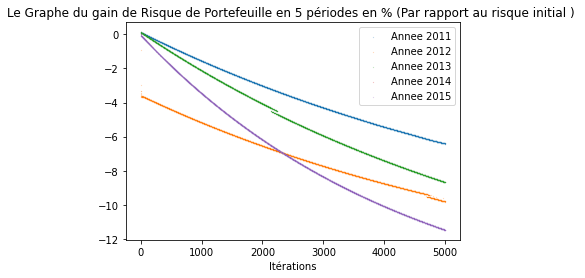

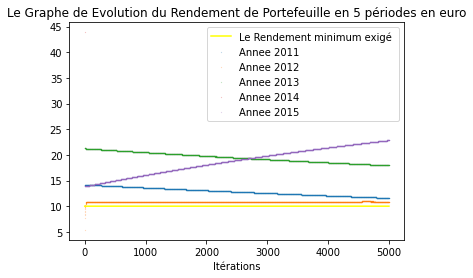

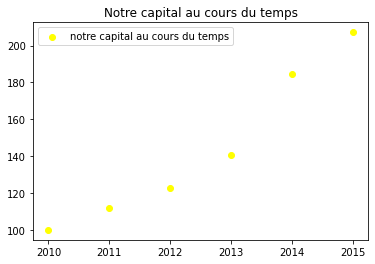

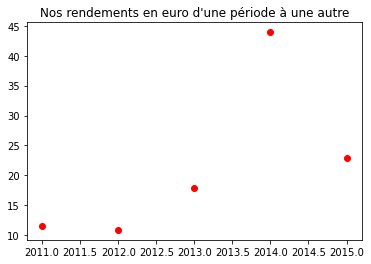

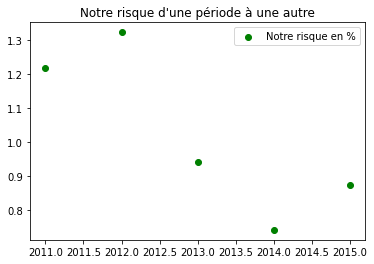

Mon rendement total est de: 107.1944168970744 % , mes positions succesives sont: [array([17.70436916, 33.49399731, 23.4347101 , 25.44064687]), array([ 5.70975858, 25.69048847, 28.63425223, 51.59197011]), array([23.76124758, 39.4667    , 33.80095704, 25.43656583]), array([35.11696319, 35.11764509, 35.11819535, 35.11774531]), array([29.8412808 , 55.92294418, 45.4456447 , 53.1290583 ])] de 2011 à 2016


In [ ]:
print(stratégie_min(n=5,S0=100,R0=10))
#n année
#S0 Mise initiale
#R0 Le rendement en euro exigé

2) En utilisant le problème de maximisation du rendement sous contrainte de risque 

In [ ]:
def strategie_max(sigma0,S0,n):
  mes_positions=[]
  ma_liquidité=[S0]
  mes_rendements_pourcent=[]
  mon_risque=[]
  Annual_yield=[]
  Annual_cov=[]
  Graphe=[]
  
  for i in range(n):
    #extraction des données  
    ticker=["AMZN","AAPL","MSFT","GOOG"]
    data=pd.DataFrame()
    data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(2010+i,1,1),end=datetime.date(2010+i+1,1,1))["Adj Close"]
    data_yield=np.log(1+data.pct_change())
    daily_yield=data_yield.mean()
    annual_yield=daily_yield*250
    data_cov=data_yield.cov()
    A=np.array(data_cov)

    #calcul des posititions succesives et de la liquidité
    xsol,Lsol,Rendements_Lsol_Reel=AlgoPenalisation(sigma0,ma_liquidité[i],np.array([ma_liquidité[i]/4,ma_liquidité[i]/4,ma_liquidité[i]/4,ma_liquidité[i]/4]),Gradf,0.2,0.01,1000,A,annual_yield)
    
    #plt.figure()
    #pd.Series(xsol).plot.barh()
    #plt.title("répartition de l'investissement")

    mes_positions.append(xsol)
    mon_risque.append(np.sqrt(F(A,xsol)))
    ma_liquidité.append(sum(xsol)+np.dot(annual_yield,xsol))
    mes_rendements_pourcent.append(np.dot(annual_yield,xsol/(sum(xsol)+np.dot(annual_yield,xsol)))*100)
    Annual_yield.append(np.array(annual_yield))
    Annual_cov.append(A)
    Graphe.append(Lsol)
  

  plt.figure()
  for k in range(n):
    xx=range(1,len(Graphe[k])+1) 
    yy=[]
    for j in range(len(Graphe[k])):
      yy.append(np.sqrt(F(Annual_cov[k],(Graphe[k][j]))))
    plt.scatter(xx,yy,s=2,label='Annee {}'.format(2011+k))
    plt.legend()
  #plt.plot([sigma0 for i in range(1,300)],label='Le Risque Maximum consenti',c='brown')
  #Peut etre utile pour visualiser la contrainte cependant attention à l'echelle 
  plt.legend()
  plt.title("Le Graphe de l'évolution du Risque (écart type réel)de Portefeuille en {} périodes   ".format(n))
  plt.xlabel("Itérations")

  plt.figure()
  for k in range(n):
    xx=range(1,len(Graphe[k])+1) 
    yy=[]
    for j in range(len(Graphe[k])):
      yy.append(100*np.dot(Annual_yield[k],(Graphe[k][j])/ma_liquidité[k]))
    plt.scatter(xx,yy,s=1,label='Annee {}'.format(2011+k))
    plt.legend()
  plt.title("Le Graphe de l'évolution du Rendement de Portefeuille (par somme engagée) en {} périodes en %".format(n))
  plt.xlabel("Itérations")

  plt.figure()
  for k in range(n):
    xx=range(1,len(Graphe[k])+1) 
    yy=[]
    for j in range(len(Graphe[k])):
      S=np.dot(Annual_yield[k],Graphe[k][j])
      yy.append(S)
    plt.scatter(xx,yy,s=0.1,label='Annee {}'.format(2011+k))
    plt.legend()
  plt.title("Le Graphe de l'évolution du Rendement de Portefeuille en {} périodes en euro".format(n))
  plt.xlabel("Itérations")



  plt.figure()
  plt.scatter(list(range(2010,2010+n+1)),ma_liquidité,label="Ma liquidité au cours du temps",c='yellow')
  plt.legend()
  plt.title("Notre capital au cours du temps")
  plt.show()
  plt.figure()
  plt.scatter(list(range(2011,2010+n+1)),mes_rendements_pourcent,c='r',label="Rendement % par rapport somme engagée sur l'année")
  plt.title("Mes rendements d'une période à une autre")
  plt.show()
  plt.figure()
  plt.scatter(list(range(2011,2010+n+1)),mon_risque,c='green',label='Mon risque réel')
  plt.legend()
  plt.title("Mon risque réel d'une période à une autre")
  plt.show()

  rendement_total=((ma_liquidité[-1]-ma_liquidité[0])/ma_liquidité[0])*100
  return ("Mon rendement total est de: {} % , mes positions succesives sont: {} de 2010 à {}".format(rendement_total,mes_positions,2011+n))


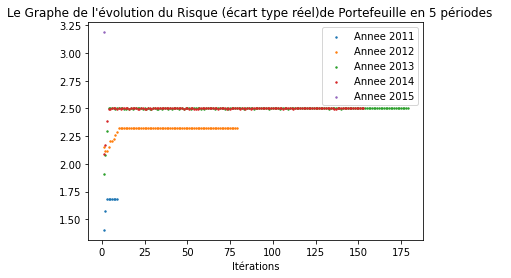

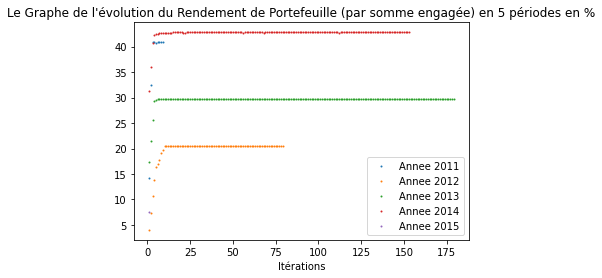

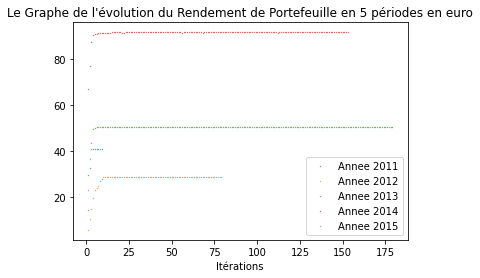

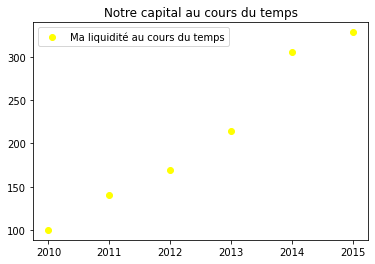

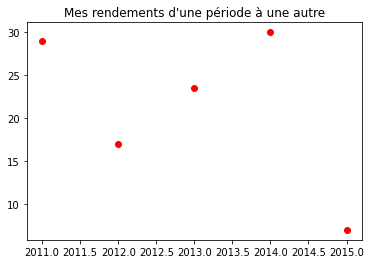

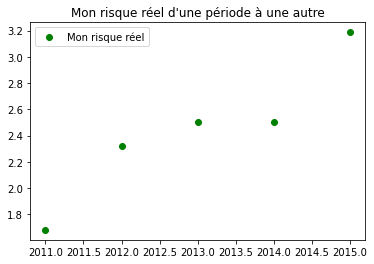

Mon rendement total est de: 228.67858861978766 % , mes positions succesives sont: [array([8.78943575e-02, 9.98636084e+01, 1.29668630e-02, 1.02503366e-02]), array([3.48776934e-02, 1.40606755e+02, 3.86901879e-02, 1.74957962e-02]), array([9.18267004e+01, 7.18313374e+01, 6.39416249e-03, 5.06098517e-02]), array([6.21701820e+01, 3.68931280e-02, 1.63701163e+01, 1.35466076e+02]), array([76.42554376, 76.42554376, 76.42554376, 76.42554376])] de 2010 à 2016


In [ ]:
print(strategie_max(2.5,100,5))
#Nous conseillons un risque autour de 2.5 pour 5 périodes pour éviter les problèmes d'echelle


## On va tracer des frontières d'efficience de Markowitz



 *On trace tout d'abord la frontière de Markowitz avec les deux algorithmes qu'on a implémenté*

In [ ]:
def notre_frontiere(les_risques,S0,i):
  mes_positions=[]
  les_rendements=[]
  les_risques1=[]
  les_risques2=[]
  mes_positions2=[]


  #extraction des données  
  ticker=["MSFT","GOOG","AF.PA","AMZN"]
  data=pd.DataFrame()
  data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(2010+i,1,1),end=datetime.date(2010+i+1,1,1))["Adj Close"] 
  data_yield=np.log(1+data.pct_change())
  data_yield.head()
  daily_yield=data_yield.mean()
  annual_yield=daily_yield*250 
  data_cov=data_yield.cov()
  A=np.array(data_cov)

  for sigma0 in les_risques:
    xsol,Lsol,Rendements_Lsol_Reel=AlgoPenalisation(sigma0,S0,np.array([S0/4,S0/4,S0/4,S0/4]),Gradf,0.2,0.01,1000,A,annual_yield)
    mes_positions2.append(xsol)
    les_rendements.append(np.dot(annual_yield,xsol)) 
    les_risques1.append(risqueportefeuille(A,xsol,S0))
  for R0 in les_rendements:
    C=np.array([np.array([1,1,1,1]),np.array([-1,-1,-1,-1]),-np.array([1,0,0,0]),-np.array([0,1,0,0]),-np.array([0,0,1,0]),-np.array([0,0,0,1]),-np.array(annual_yield)])
    g=np.transpose(np.array([S0,-S0,0,0,0,0,-R0]))
    #positions et liquidité 
    xsol,Lsol=gradientPasConstant(A,C,g,df,PK,np.array([S0/4,S0/4,S0/4,S0/4]),0.001, Niter=5000)
    mes_positions.append(xsol)
    les_risques2.append(risqueportefeuille(A,xsol,S0))
  #return les_risques, mes_positions
  plt.figure()
  plt.scatter(les_risques1,les_rendements,c='r', label="méthode max")
  plt.scatter(les_risques2,les_rendements,c='green',label="méthode min")
  plt.title("frontière de Markowitz")
  plt.xlabel("volatilité")
  plt.ylabel("rendement en somme pour une mise de 100 euros")
  plt.legend()
  plt.show()


  return les_risques1,les_rendements,les_risques2
  


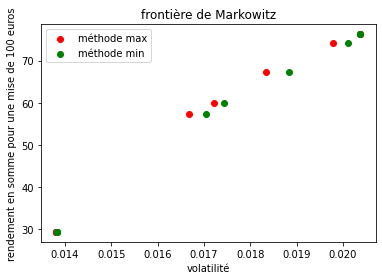

([0.01381111782624921, 0.01381111782624921, 0.01381111782624921, 0.01666980969351752, 0.017225172546943307, 0.01381111782624921, 0.018345885504284877, 0.01979074161728323, 0.02036545546501848, 0.020366066920710933], [29.406229236899858, 29.406229236899858, 29.406229236899858, 57.38647007157183, 59.9446437996607, 29.406229236899858, 67.32672407015887, 74.08252775867928, 76.23670060391193, 76.23870665066298], [0.013832384989276648, 0.013832384989276648, 0.013832384989276648, 0.017047050631326475, 0.0174367404520017, 0.013832384989276648, 0.018844275618630314, 0.0200972555836281, 0.020374392980018037, 0.020374652068359787])


In [ ]:
print(notre_frontiere(np.linspace(1.5,2,10),100,5))
#Attention algorithme avec une implémentation très longue
# nous conseillons une mise de 100 euros et un range d'écart type réel entre 1.5 et 2 pour bien faire apparaître la frontière 

*On trace également la frontière de Markowitz avec un algo issu du Package PyPortfolioOpt et notre descente de gradient*

In [ ]:
pip install PyPortfolioOpt

In [ ]:
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import EfficientFrontier

In [ ]:
def python_frontiere(les_risques,S0,i):
  mes_positions=[]
  les_rendements=[]
  les_risques1=[]
  les_risques2=[]
  mes_positions2=[]
  #extraction des données  
  ticker=["MSFT","GOOG","AF.PA","AMZN"]
  data=pd.DataFrame()
  data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(2010+i,1,1),end=datetime.date(2010+i+1,1,1))["Adj Close"]
  data_yield=np.log(1+data.pct_change())
  data_yield.head()
  daily_yield=data_yield.mean() 
  annual_yield=daily_yield*250 
  data_cov=data_yield.cov()
  A=np.array(data_cov)

  for sigma0 in les_risques:
    ef = EfficientFrontier(annual_yield,data_cov)
    ef.efficient_risk(target_volatility=sigma0)
    xsol = np.array(list(ef.clean_weights().values()))
    mes_positions2.append(xsol)
    les_rendements.append(np.dot(annual_yield,S0*xsol)) 
    les_risques1.append(risqueportefeuille(A,xsol,1))
  for R0 in les_rendements:
    #matrice C de contrainte et g 
    #R0 rendement min à atteindre sur une année ,S0 somme initiale
    C=np.array([np.array([1,1,1,1]),np.array([-1,-1,-1,-1]),-np.array([1,0,0,0]),-np.array([0,1,0,0]),-np.array([0,0,1,0]),-np.array([0,0,0,1]),-np.array(annual_yield)])
    g=np.transpose(np.array([S0,-S0,0,0,0,0,-R0]))
    #positions et liquidité 
    xsol,Lsol=gradientPasConstant(A,C,g,df,PK,np.array([S0/4,S0/4,S0/4,S0/4]),0.001, Niter=5000)
    mes_positions.append(xsol)
    les_risques2.append(risqueportefeuille(A,xsol,S0))

  print(les_risques1,"risque de max ")
  print(les_rendements,"les rendements")
  print(les_risques2,"les risques min ")
  plt.figure()
  plt.scatter(les_risques1,les_rendements,c='r', label="méthode max")
  plt.scatter(les_risques2,les_rendements,c='green',label="méthode min")
  plt.title("frontière de Markowitz")
  plt.xlabel("volatilité")
  plt.ylabel("rendement en somme pour une mise de 100 euros")
  plt.title("frontière de Markowitz avec l'algo PyPortfolioOpt et la descente de gradient")
  plt.legend()
  plt.show()
  
  return les_risques1,les_rendements,les_risques2




In [ ]:
print(python_frontiere(np.linspace(0.015,0.020,50),100,5))
# nous conseillons une somme initiale de 100 et un range de volatilité entre 1.5% et 2.0%

##Comparaison de l'algorithme de pénalisation et celui issu du package PyPortfolioOpt

In [ ]:
## on compare sans multiplier la matrice de covariance par 250 pour pouvoir comparer 
# Attention le risque que prend en argument la fonction pénalisation est un risque en réel ( des mises au lieu de poids) pour une mise de 100 euros 
# On va comparer les algorithmes sur la période 2015-2016

# on se donne un range de risque et on va comparer les performances de nos algorithmes 
def comparaison(volatilite,volatilite_reelle,S0=100): 
  les_solutions1=[]
  les_solutions2=[]
  les_rendements1=[]
  les_rendements2=[]
  #extraction des données  
  ticker=["MSFT","GOOG","AF.PA","AMZN"]
  data=pd.DataFrame()
  data[ticker]=wb.DataReader(ticker,data_source="yahoo",start=datetime.date(2010+5,1,1),end=datetime.date(2010+5+1,1,1))["Adj Close"]
  data_yield=np.log(1+data.pct_change())
  data_yield.head()
  daily_yield=data_yield.mean() 
  annual_yield=daily_yield*250 
  data_cov=data_yield.cov()
  A=np.array(data_cov)

  for v0 in volatilite:
    ef = EfficientFrontier(annual_yield,data_cov)
    ef.efficient_risk(target_volatility=v0)
    xsol1 = np.array(list(ef.clean_weights().values()))
    les_solutions1.append(xsol1)
    les_rendements1.append(np.dot(annual_yield,xsol1))
  for sigma0 in volatilite_reelle:
    xsol2,Lsol,Rendements_Lsol_Reel=AlgoPenalisation(sigma0,S0,np.array([S0/4,S0/4,S0/4,S0/4]),Gradf,0.2,0.01,1000,A,annual_yield)
    les_solutions2.append(xsol2)
    les_rendements2.append(np.dot(annual_yield,xsol2)/S0)

  plt.figure()
  plt.scatter(volatilite,les_rendements1,c="red",label="algo du package PyPortfolioOpt")
  plt.scatter(volatilite,les_rendements2,c="green",label="algo pénalisation")
  plt.xlabel("la volatilité maximale acceptée")
  plt.ylabel("le rendement du portefeuille optimal")
  plt.title("comparaison de l'algo PyPortfolioOpt et pénalisation")
  plt.legend()
  plt.show()



    




In [ ]:
volatilite=np.linspace(0.015,0.020,10)
volatilite_reelle=volatilite*100
print(comparaison(volatilite,volatilite_reelle))
#Attention implémentation longue de l'algorithme
## nous conseillons une somme initiale de 100 et un range de volatilité entre 1.5% et 2.0%